In [1]:
%%capture output
!pip install brian2
!pip install -q condacolab
import condacolab
condacolab.install()
!conda create -y -n opensim_env python=3.10
!source /usr/local/etc/profile.d/conda.sh && conda activate opensim_env && conda install -y -c opensim-org opensim pandas
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/activation.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/muscle_sim.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/neural_simulations.py
!wget https://raw.githubusercontent.com/MathieuCharbonnier/Loop/refs/heads/main/plot_time_series.py



In [1]:
%%capture output
!unzip Model.zip

In [2]:
%load_ext autoreload
%autoreload 2

from brian2 import *
import numpy as np
import pandas as pd
import os
import subprocess
import tempfile
import json
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from collections import defaultdict

from plot_time_series import plot_times_series
from neural_simulations import run_neural_simulations
from activation import decode_spikes_to_activation


In [43]:
def RampHold(T_reaction, dt, v=0.2, t_ramp=0.1*second, t_hold=0.3*second, plot=False):

  time = np.arange(0, T_reaction, dt)

  stretch = np.piecewise(
      time,
      [time < t_ramp/second,
      (time >= t_ramp/second) & (time < t_hold/second),
      time >= t_hold/second],
      [lambda t: v * t,
      lambda t: v * t_ramp/second,
      lambda t: v * t_ramp/second - v * (t - t_hold/second)]
  )
  velocity = np.gradient(stretch, dt)
  if plot:
    plt.plot(time, stretch)
    plt.xlabel('Time (s)')
    plt.ylabel('Stretch (a.u)')
    plt.title('Initial Ramp-Hold Stretch Profile')
    plt.show()
  return stretch, velocity

def SinusoidalStretch(dt,T_reaction, A=0.01, f=2*hertz, plot=False):

  time = np.arange(0, T_reaction, dt)
  stretch = A * np.sin(2 * np.pi * f/hertz * time)
  velocity = np.gradient(stretch, dt)
  if plot:
    plt.plot(time, stretch)
    plt.xlabel('Time (s)')
    plt.ylabel('Stretch (a.u)')
    plt.title('Initial Sinusoidal Stretch Profile')
    plt.show()

  return stretch, velocity

def NoInput(dt, T_reaction):

  time = np.arange(0, T_reaction, dt)
  stretch = np.zeros_like(time)
  velocity = np.zeros_like(time)
  return stretch, velocity


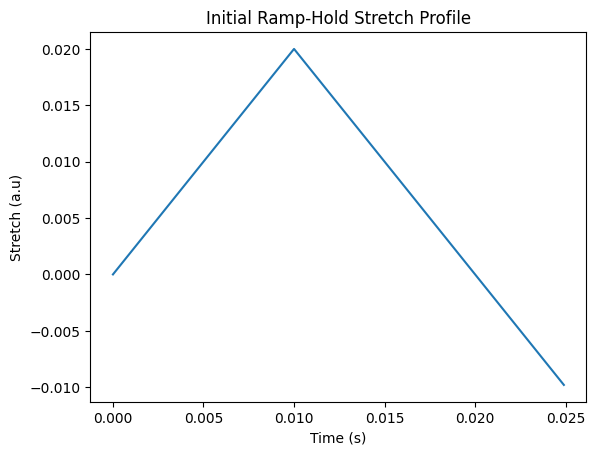

--- Iteration 1 ---
--- Iteration 2 ---


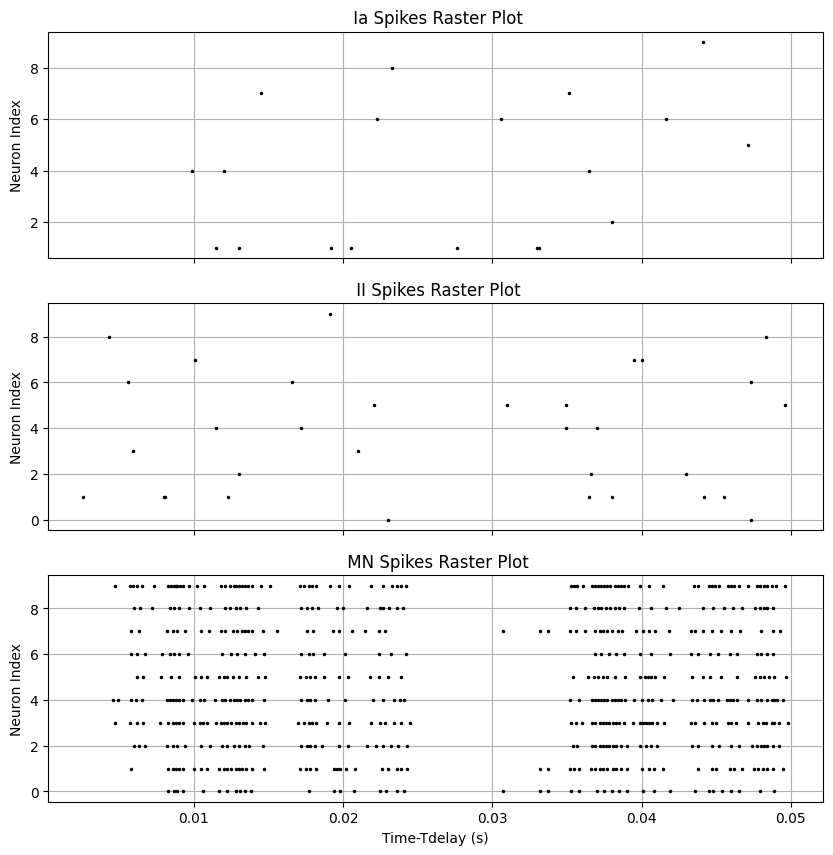

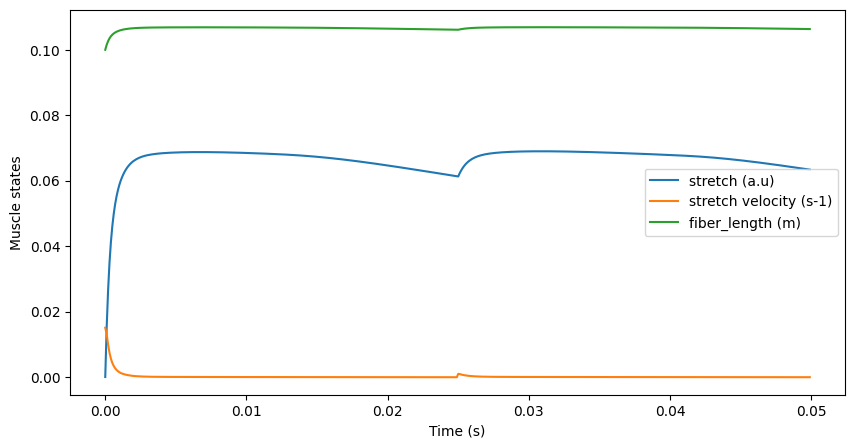

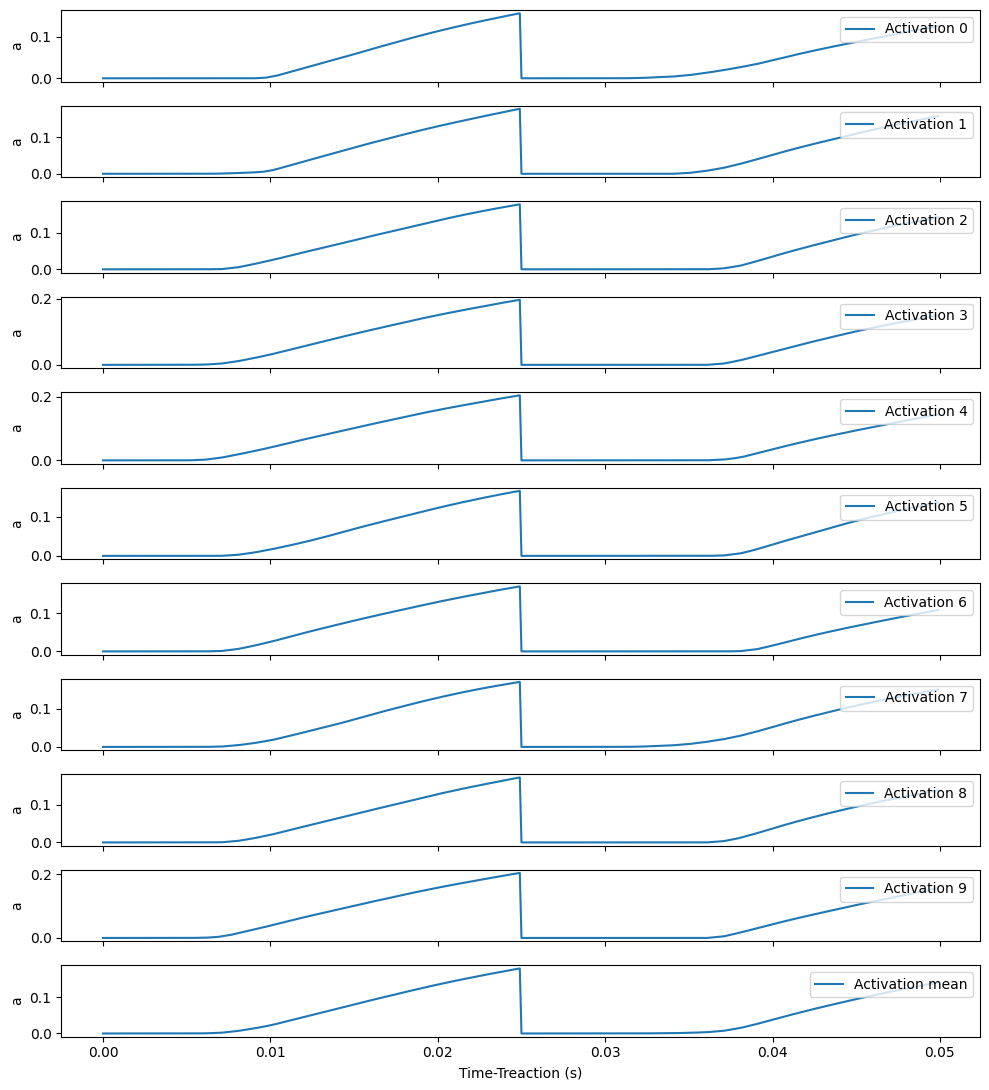

In [52]:
total_time= 1*second
t_stretching_afferent = 15*ms
t_motoneuron_muscle = 10*ms
t_reaction = t_stretching_afferent + t_motoneuron_muscle
#n_loop = int(total_time/t_reaction)
n_loop=2
dt = 0.1*ms

name_output_spikes = 'spikes.json'
name_output_muscle='df_muscle.csv'

neuron_population = {"Ia": 10, "II": 10, "exc": 10, "motor": 10}
muscle_name = "iliacus_r"
resting_length = 10*cm
stretch, velocity = RampHold(t_reaction, dt, v=2, t_ramp=10*ms, t_hold=10*ms, plot=True)

data_muscle = []
data_spikes = {
    "Ia": defaultdict(list),
    "II": defaultdict(list),
    "MN": defaultdict(list)
}
current_length=resting_length/meter
for j in range(n_loop):

    print(f"--- Iteration {j+1} ---")
    spikes_all=run_neural_simulations(stretch, velocity, neuron_population,dt,t_reaction, w_run=500*uS, p_run=0.4 )
    for fiber_name, fiber_spikes in spikes_all.items():
      for neuron_id, spikes in fiber_spikes.items():
        data_spikes[fiber_name][neuron_id].extend(spikes/second+j*t_reaction/second)

    activations=decode_spikes_to_activation([value/second for key, value in spikes_all["MN"].items()], dt/second, t_reaction/second)
    mean_activation = np.mean(activations, axis=0)

    # Create temporary files for both input and output
    with tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as input_tmp, \
        tempfile.NamedTemporaryFile(suffix='.npy', delete=False) as output_tmp:

        input_path = input_tmp.name
        output_path = output_tmp.name
        np.save(input_path, mean_activation)

        # Run the script in the other environment, passing both file paths
        process=subprocess.run([
            'conda', 'run', '-n', 'opensim_env', 'python', 'muscle_sim.py',
            '--dt', str(dt/second),
            '--T', str(t_reaction/second),
            '--muscle', muscle_name,
            '--L', str(current_length),
            '--input_file', input_path,
            '--output_file', output_path
        ], capture_output=True, text=True)

        #if process.stdout.strip():
            #print("STDOUT:\n", process.stdout)

        if process.returncode == 0 and os.path.getsize(output_path) > 0:
            fiber_length=np.load(output_path)
            current_length=fiber_length[-1]
            fiber_length=fiber_length[:-1]
            stretch=fiber_length/(resting_length/meter)-1

            # Create batch data dictionary
            batch_data_muscle = {
              **{f'activation_{i}': activations[i] for i in range(neuron_population['motor'])},
              'activation_mean': mean_activation,
              'fiber_length': fiber_length,
              'stretch': stretch,
              'velocity': np.gradient(stretch)
            }
            data_muscle.append(pd.DataFrame(batch_data_muscle))
        else:
          raise RuntimeError(f'Problem in iteration {j}. STDERR: {process.stderr}')

        # Clean up temporary files
        os.unlink(input_path)
        os.unlink(output_path)

df_muscle = pd.concat(data_muscle)
df_muscle['Time']=np.arange(0, len(df_muscle)*dt, dt)
df_muscle.to_csv(name_output_muscle, index=False)

with open(name_output_spikes, "w") as f:
    json.dump(data_spikes, f, indent=4)

plot_times_series(name_output_spikes, name_output_muscle)